## 1. Set Up

In [1]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 8.1 MB/s eta 0:00:00


In [2]:
#Am I running a GPU and what type is it?
!nvidia-smi

Sat Apr  1 17:51:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch

if torch.cuda.is_available():     
    device = torch.device("cuda")
    print('Number of GPU(s) available:', torch.cuda.device_count())
    print('GPU device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available')
    device = torch.device("cpu")
     

Number of GPU(s) available: 1
GPU device name: Tesla T4


In [4]:
from logging import warning
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.backends.cudnn as cudnn
import torch.optim as optim

from transformers import BertTokenizer, BertModel

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# from sklearn.utils import resample
# from sklearn.model_selection import train_test_split

import re
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pprint
import os
import shutil
import time
import datetime
from collections import Counter

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

pd.set_option('display.max_colwidth', 100)
sns.set(style='whitegrid')


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd drive/MyDrive/w266

/content/drive/MyDrive/w266


In [ ]:
# !git clone https://github.com/hjesse92/style_transfer_w266.git

In [8]:
cd style_transfer_w266/

/content/drive/MyDrive/w266/style_transfer_w266


In [9]:
!ls data/

jigsaw_classification_data.csv	original-train.tsv
original-dev.tsv		upsampling_classification_data.csv
original-test.tsv


## 2. EDA

In [10]:
train_text_file = 'data/original-train.tsv'
dev_text_file = 'data/original-dev.tsv'
test_text_file = 'data/original-test.tsv'

In [11]:
def load_data(text_file):
  """Load data and rename column"""
  df = pd.read_csv(text_file, sep="\t")
  df = df.rename(columns={'offensive-text':'org', 'style-transferred-text': 'mod'})
  
  # Calculate text length / word counts
  df['org_text_length'] = df['org'].apply(lambda x: len(x.split(' ')))
  df['mod_text_length'] = df['mod'].apply(lambda x: len(x.split(' ')))

  return df

In [12]:
def modify_text_to_print(df_original):
  """Modify some toxic, offensive texts in the datafram for printing out"""
  df = df_original.copy()
  df["org"] = df["org"].apply(lambda x: x.lower().replace('fuck', 'f***')\
                              .replace('shit', 's***')\
                              .replace('rape', 'r***')\
                              .replace('dick', 'd***')\
                              .replace('pussy', 'p***y'))

  return df

In [13]:
train_df = load_data(train_text_file)
dev_df = load_data(dev_text_file)
test_df = load_data(test_text_file)

print('Train data size:', train_df.shape[0])
print('Dev data size:', dev_df.shape[0])
print('Test data size:', test_df.shape[0])

print('\nTrain data overview:')
modify_text_to_print(train_df[["org", "mod"]])

Train data size: 1584
Dev data size: 198
Test data size: 199

Train data overview:


,org,mod
0,p***y nobody asked for your input.,Nobody asked for your input
1,"ok, this makes no sense. this will create vigilantes. and i hope they put this savage animal dow...","Ok, this makes no sense. This will create vigilantes. And I hope they take care of this uncontro..."
2,so f***ing true. the amount of up and coming rappers that are shot dead or od is is so f***ing s...,so true. the amount of up and coming rappers that are shot dead or od is is so sad.
3,go f yourself republican scum who put us here with your uneducated voting like you even care. i ...,Republicans put us in this situation. I would want to defund the police.
4,dumb f***ing take. people want to do things.,That's not a smart take. People want to do things.
...,...,...
1579,"the view! and this crap hits my front page!? lmfao i know it's mostly bots but still, /r/polit...","This must be mostly bots but still, it's strange for /r/politics."
1580,that’s racist.,Those actions are racist.
1581,cultural marxism isn't a thing you weird f***.,Cultural Marxism isn't a thing.
1582,"lol, anyone that questions the democrat program is always a russian asset or nazi. this s***s ol...","LOL, anyone that questions the Democrat program is always considered back. This is getting old, ..."


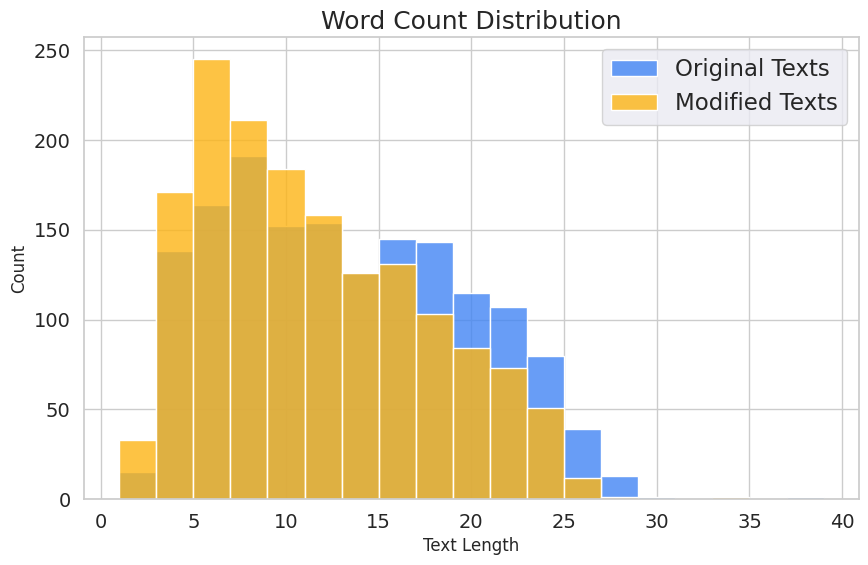

In [14]:
### Plot the word-count distribution for the original texts and the modified texts.
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_style('white')
sns.set(font_scale=1.5)

# calculate the bin size based on the range of the data
bins = range(min(train_df['org_text_length'].min(), train_df['mod_text_length'].min()), 
             max(train_df['org_text_length'].max(), train_df['mod_text_length'].max()) + 2, 2)

# plot the histograms with the same bin size
sns.histplot(data=train_df, x='org_text_length', label='Original Texts', bins=bins, color='#4285F4', alpha=0.8)
sns.histplot(data=train_df, x='mod_text_length', label='Modified Texts', bins=bins, color='#FDB515', alpha=0.8)

# set the axis labels and title
ax.set(xlabel='Text Length', ylabel='Count')
ax.set_title('Word Count Distribution', fontsize=18)

# set the legend and adjust its position
plt.legend(fontsize=14)
plt.legend(loc='upper right')

# set the ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=14)

In [15]:
### Find out what words appear the most in the original texts and the modified text without including the stopwords

# create a list of stopwords
stop_words = set(stopwords.words('english')) | {"i'm", "you’re", "that's"}

# create a list of all words in the 'org' column, removing stopwords
org_words = ' '.join(train_df['org']).lower().split()
org_words = [word.strip(".,?!:").replace('fuck', 'f***').replace('shit', 's***') for word in org_words if word not in stop_words]
# org_words = [word.lower() for word in train_df['org'].str.split() if word.lower() not in stop_words]

# create a list of all words in the 'mod' column, removing stopwords
mod_words = ' '.join(train_df['mod']).lower().split()
mod_words = [word.strip(".,?!:") for word in mod_words if word not in stop_words]
# mod_words = [word.lower() for word in train_df['mod'].str.split() if word.lower() not in stop_words]

# count the frequency of each word in the 'org' column
org_word_counts = Counter(org_words)

# count the frequency of each word in the 'mod' column
mod_word_counts = Counter(mod_words)

# create a pandas dataframe of the top 20 most common words in each column
top_org_words = pd.DataFrame(org_word_counts.most_common(20), columns=['word', 'count'])
top_mod_words = pd.DataFrame(mod_word_counts.most_common(20), columns=['word', 'count'])

# print the top 20 most common words in each column
print("Top 20 most frequent words in the Original Texts:")
print(top_org_words)
print("\nTop 20 most frequent words in the Modified Texts:")
print(top_mod_words)

Top 20 most frequent words in the Original Texts:
       word  count
0      f***    170
1      s***    158
2   f***ing    138
3      like    119
4    people     90
5    stupid     84
6       get     78
7      dumb     57
8      even     52
9      know     52
10    think     52
11      lol     51
12    idiot     50
13       go     48
14      one     45
15   really     43
16      ass     43
17   racist     42
18     good     42
19    right     38

Top 20 most frequent words in the Modified Texts:
      word  count
0   people    129
1     like    104
2      get     78
3    think     67
4   really     58
5     know     52
6   person     51
7     good     49
8     make     48
9     stop     47
10    even     46
11     one     46
12    need     46
13      go     45
14     bad     44
15      it     43
16   would     37
17     lol     35
18  racist     34
19   stuff     34


In [ ]:
# from datasets import load_dataset
# train_ds = load_dataset("csv", data_files=train_text_file, sep="\t", names=["org","mod"])
# train_ds
# print(train_ds["train"][:5])

## 3. Evaluate Detoxify Dataset with NonToxicScore Classification Model

*   Using the Toxic DistilBert Classification model to evaluate the detoxify dataset
*   Column `org` should be classified as being toxic Or having low non-toxic score
*   Column `mod` should be classified as being non-toxic Or having high non-toxic score





### 3.1. With DistilBERT Undersampling 64 Tokens Model 

In [16]:
# Clear out cuda
torch.cuda.empty_cache()

In [17]:
import sys
sys.path.append('./notebooks')
from DistilBertClassification import BertClassificationML

class_model = BertClassificationML()
class_model = class_model.to(device)

pretrained_weights = torch.load('models/DistilBertToxicClassification5.pth')
class_model.load_state_dict(pretrained_weights )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [29]:
# Get pair-wise toxic and non-toxic (transfered-style) data
train_toxic = pd.DataFrame({'comment_text':train_df["org"], 'label': np.zeros(len(train_df))})

train_nontoxic = pd.DataFrame({'comment_text':train_df["mod"], 'label': np.ones(len(train_df))})

test_toxic = pd.DataFrame({'comment_text':test_df["org"], 'label': np.zeros(len(test_df))})

test_nontoxic = pd.DataFrame({'comment_text':test_df["mod"], 'label': np.ones(len(test_df))})

print('Train Set Toxic Data Dimension:', train_toxic.shape)
print('Train Set NonToxic Data Dimension:', train_nontoxic.shape)
print('Test Set Toxic Data Dimension:', test_toxic.shape)
print('Test Set NonToxic Data Dimension:', test_nontoxic.shape)

Train Set Toxic Data Dimension: (1584, 2)
Train Set NonToxic Data Dimension: (1584, 2)
Test Set Toxic Data Dimension: (199, 2)
Test Set NonToxic Data Dimension: (199, 2)


In [30]:
test_nontoxic

,comment_text,label
0,So maybe you should be more backward,1.0
1,THERES ACTUALLY A MEGATHREAD FOR VACCINE OR COVID RELATED TOPICS. DON'T TALK ABOUT THAT STUFF HERE!,1.0
2,uh..... you are not being realistic,1.0
3,You should leave him. Tablemanners are no rocket science. Treating other people like human being...,1.0
4,Youre really soft,1.0
...,...,...
194,"NTA, your brother is not thinking straight. How long did he think he could keep these kids hidde...",1.0
195,Formula one…nascar….it exactly the same except the former has lighter cars. Who can turn left ...,1.0
196,"BRB, gonna go call the mods.",1.0
197,Carlson is the problem,1.0


In [31]:
from transformers import DistilBertTokenizer

bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def ClassificationDataLoader(output_df, max_length=64, tokenizer=bert_tokenizer):
    # Load DistilBERT tokenizer
    output_encodings = tokenizer(
        list(output_df['comment_text'].values), 
        max_length=max_length,
        truncation=True,
        pad_to_max_length=True, 
        return_tensors='pt'
    )

    input_ids = output_encodings.input_ids.to(device, dtype = torch.long)
    attention_mask = output_encodings.attention_mask.to(device, dtype = torch.long)
    labels = torch.tensor(output_df['label'].values).to(device) 

    output_dataset = TensorDataset(input_ids, attention_mask, labels)
    output_loader = DataLoader(output_dataset, batch_size=16)


    return output_loader

In [32]:
# Create data loader for APPDIA toxic & non-toxic texts
train_toxic_loader = ClassificationDataLoader(train_toxic, max_length=64)
train_nontoxic_loader = ClassificationDataLoader(train_nontoxic, max_length=64)
test_toxic_loader = ClassificationDataLoader(test_toxic, max_length=64)
test_nontoxic_loader = ClassificationDataLoader(test_nontoxic, max_length=64)

In [35]:
from DistilBertClassification import validate, compute_metrics

## Get prediction accuracy & NonToxicScore with Classification Model
print('Train Set Toxic Text evaluation:')
train_toxic_outputs, train_toxic_targets, train_toxic_loss = validate(train_toxic_loader , model=class_model)
train_toxic_accuracy = compute_metrics(train_toxic_outputs, train_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTrain Set Non-Toxic Text evaluation:')           
train_nontoxic_outputs, train_nontoxic_targets, train_nontoxic_loss = validate(train_nontoxic_loader, model=class_model)
train_nontoxic_accuracy = compute_metrics(train_nontoxic_outputs, train_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(train_nontoxic_outputs)))

Train Set Toxic Text evaluation:
Accuracy 0.9312 

NonToxicScore: 0.0917


######
Train Set Non-Toxic Text evaluation:
Accuracy 0.6673 

NonToxicScore for the style-transfered posts: 0.6637


In [37]:
## Get prediction accuracy with Classification Model
print('Test Set Toxic Text evaluation:')
test_toxic_outputs, test_toxic_targets, test_toxic_loss = validate(test_toxic_loader , model=class_model)
test_toxic_accuracy = compute_metrics(test_toxic_outputs, test_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTest Set Non-Toxic Text evaluation:')           
test_nontoxic_outputs, test_nontoxic_targets, test_nontoxic_loss = validate(test_nontoxic_loader, model=class_model)
test_nontoxic_accuracy = compute_metrics(test_nontoxic_outputs, test_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(test_nontoxic_outputs)))

Test Set Toxic Text evaluation:
Accuracy 0.9347 

NonToxicScore: 0.0917


######
Test Set Non-Toxic Text evaluation:
Accuracy 0.6633 

NonToxicScore for the style-transfered posts: 0.6451


In [38]:
## Example Nontoxic Score detailed
example_texts = ["Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal down before he hurts anyone else.",
                 "This is really disgusting.  People not able to compete even in the 3rd men league getting paid twice as much.",
                 "Good lord you people are fucking stupid.",
                 "Yeah, no. And for that go away.",
                 "Holy moly this sub is gross",
                 "Oh joy can’t wait for all of you irrational people to misunderstand this science too. 🙄"
                 ] 
example_labels = [0., 0., 0., 1., 1., 1.]
example_df = pd.DataFrame({'comment_text':example_texts, 'label': example_labels})
example_df

,comment_text,label
0,"Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal dow...",0.0
1,This is really disgusting. People not able to compete even in the 3rd men league getting paid t...,0.0
2,Good lord you people are fucking stupid.,0.0
3,"Yeah, no. And for that go away.",1.0
4,Holy moly this sub is gross,1.0
5,Oh joy can’t wait for all of you irrational people to misunderstand this science too. 🙄,1.0


In [44]:
# Create data loader
example_loader = ClassificationDataLoader(example_df, max_length=64)

# Extract NonToxicScore for the examples
example_outputs, example_targets, example_loss = validate(example_loader , model=class_model)
example_accuracy = compute_metrics(example_outputs, example_targets)

print('NonToxicScore: {:.4f}'.format(np.mean(example_outputs)))

Accuracy 0.6667 

NonToxicScore: 0.1841


In [48]:
example_output_df = pd.DataFrame({'comment_text':example_texts, 
                                  'label': example_labels,
                                  'NonToxicScore': example_outputs, 
                                  'predicted_label':(np.array(example_outputs) >= 0.5).astype(float)})
example_output_df

,comment_text,label,NonToxicScore,predicted_label
0,"Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal dow...",0.0,0.082516,0.0
1,This is really disgusting. People not able to compete even in the 3rd men league getting paid t...,0.0,0.025709,0.0
2,Good lord you people are fucking stupid.,0.0,0.004504,0.0
3,"Yeah, no. And for that go away.",1.0,0.895549,1.0
4,Holy moly this sub is gross,1.0,0.057019,0.0
5,Oh joy can’t wait for all of you irrational people to misunderstand this science too. 🙄,1.0,0.039433,0.0


### 3.2. With DistilBERT UpSampling 64 Tokens Model


In [49]:
# Load Upsampling model
class_model = BertClassificationML()
class_model = class_model.to(device)

pretrained_weights = torch.load('models/DistilBertToxicClassification6.pth')
class_model.load_state_dict(pretrained_weights )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [50]:
## Get prediction accuracy & NonToxicScore with Classification Model
print('Train Set Toxic Text evaluation:')
train_toxic_outputs, train_toxic_targets, train_toxic_loss = validate(train_toxic_loader , model=class_model)
train_toxic_accuracy = compute_metrics(train_toxic_outputs, train_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTrain Set Non-Toxic Text evaluation:')           
train_nontoxic_outputs, train_nontoxic_targets, train_nontoxic_loss = validate(train_nontoxic_loader, model=class_model)
train_nontoxic_accuracy = compute_metrics(train_nontoxic_outputs, train_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(train_nontoxic_outputs)))

Train Set Toxic Text evaluation:
Accuracy 0.9457 

NonToxicScore: 0.0784


######
Train Set Non-Toxic Text evaluation:
Accuracy 0.8857 

NonToxicScore for the style-transfered posts: 0.8404


In [51]:
## Get prediction accuracy with Classification Model
print('Test Set Toxic Text evaluation:')
test_toxic_outputs, test_toxic_targets, test_toxic_loss = validate(test_toxic_loader , model=class_model)
test_toxic_accuracy = compute_metrics(test_toxic_outputs, test_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTest Set Non-Toxic Text evaluation:')           
test_nontoxic_outputs, test_nontoxic_targets, test_nontoxic_loss = validate(test_nontoxic_loader, model=class_model)
test_nontoxic_accuracy = compute_metrics(test_nontoxic_outputs, test_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(test_nontoxic_outputs)))

Test Set Toxic Text evaluation:
Accuracy 0.8894 

NonToxicScore: 0.0784


######
Test Set Non-Toxic Text evaluation:
Accuracy 0.8241 

NonToxicScore for the style-transfered posts: 0.7842


In [54]:
# Extract NonToxicScore for the examples
print('Example Data evaluation:')
example_outputs, example_targets, example_loss = validate(example_loader , model=class_model)
example_accuracy = compute_metrics(example_outputs, example_targets)

print('NonToxicScore: {:.4f}'.format(np.mean(example_outputs)))

Example Data evaluation:
Accuracy 0.6667 

NonToxicScore: 0.3152


In [53]:
example_output_df = pd.DataFrame({'comment_text':example_texts, 
                                  'label': example_labels,
                                  'NonToxicScore': example_outputs, 
                                  'predicted_label':(np.array(example_outputs) >= 0.5).astype(float)})
example_output_df

,comment_text,label,NonToxicScore,predicted_label
0,"Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal dow...",0.0,0.148001,0.0
1,This is really disgusting. People not able to compete even in the 3rd men league getting paid t...,0.0,0.063848,0.0
2,Good lord you people are fucking stupid.,0.0,0.001646,0.0
3,"Yeah, no. And for that go away.",1.0,0.984094,1.0
4,Holy moly this sub is gross,1.0,0.201017,0.0
5,Oh joy can’t wait for all of you irrational people to misunderstand this science too. 🙄,1.0,0.492425,0.0


### 3.3. With DistilBERT Undersampling 512 Tokens Model

In [56]:
# Load Undersampling 512 Tokens model
class_model = BertClassificationML()
class_model = class_model.to(device)

pretrained_weights = torch.load('models/DistilBertToxicClassification512.pth')
class_model.load_state_dict(pretrained_weights )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [57]:
# Create data loader for APPDIA toxic & non-toxic texts
train_toxic_loader = ClassificationDataLoader(train_toxic, max_length=512)
train_nontoxic_loader = ClassificationDataLoader(train_nontoxic, max_length=512)
test_toxic_loader = ClassificationDataLoader(test_toxic, max_length=512)
test_nontoxic_loader = ClassificationDataLoader(test_nontoxic, max_length=512)
example_loader = ClassificationDataLoader(example_df, max_length=512)

In [58]:
## Get prediction accuracy & NonToxicScore with Classification Model
print('Train Set Toxic Text evaluation:')
train_toxic_outputs, train_toxic_targets, train_toxic_loss = validate(train_toxic_loader , model=class_model)
train_toxic_accuracy = compute_metrics(train_toxic_outputs, train_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTrain Set Non-Toxic Text evaluation:')           
train_nontoxic_outputs, train_nontoxic_targets, train_nontoxic_loss = validate(train_nontoxic_loader, model=class_model)
train_nontoxic_accuracy = compute_metrics(train_nontoxic_outputs, train_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(train_nontoxic_outputs)))

Train Set Toxic Text evaluation:
Accuracy 0.9306 

NonToxicScore: 0.0909


######
Train Set Non-Toxic Text evaluation:
Accuracy 0.6711 

NonToxicScore for the style-transfered posts: 0.6664


In [59]:
## Get prediction accuracy with Classification Model
print('Test Set Toxic Text evaluation:')
test_toxic_outputs, test_toxic_targets, test_toxic_loss = validate(test_toxic_loader , model=class_model)
test_toxic_accuracy = compute_metrics(test_toxic_outputs, test_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTest Set Non-Toxic Text evaluation:')           
test_nontoxic_outputs, test_nontoxic_targets, test_nontoxic_loss = validate(test_nontoxic_loader, model=class_model)
test_nontoxic_accuracy = compute_metrics(test_nontoxic_outputs, test_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(test_nontoxic_outputs)))

Test Set Toxic Text evaluation:
Accuracy 0.9095 

NonToxicScore: 0.0909


######
Test Set Non-Toxic Text evaluation:
Accuracy 0.6332 

NonToxicScore for the style-transfered posts: 0.6301


In [60]:
# Extract NonToxicScore for the examples
print('Example Data evaluation:')
example_outputs, example_targets, example_loss = validate(example_loader , model=class_model)
example_accuracy = compute_metrics(example_outputs, example_targets)

print('NonToxicScore: {:.4f}'.format(np.mean(example_outputs)))

Example Data evaluation:
Accuracy 0.6667 

NonToxicScore: 0.2222


In [61]:
example_output_df = pd.DataFrame({'comment_text':example_texts, 
                                  'label': example_labels,
                                  'NonToxicScore': example_outputs, 
                                  'predicted_label':(np.array(example_outputs) >= 0.5).astype(float)})
example_output_df

,comment_text,label,NonToxicScore,predicted_label
0,"Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal dow...",0.0,0.191185,0.0
1,This is really disgusting. People not able to compete even in the 3rd men league getting paid t...,0.0,0.030778,0.0
2,Good lord you people are fucking stupid.,0.0,0.003108,0.0
3,"Yeah, no. And for that go away.",1.0,0.881172,1.0
4,Holy moly this sub is gross,1.0,0.150815,0.0
5,Oh joy can’t wait for all of you irrational people to misunderstand this science too. 🙄,1.0,0.075847,0.0


### 3.4. With DistilBERT UpSampling 512 Tokens Model

In [62]:
# Load Upsampling 512 tokens model
class_model = BertClassificationML()
class_model = class_model.to(device)

pretrained_weights = torch.load('models/DistilBertToxicClassification7.pth')
class_model.load_state_dict(pretrained_weights )

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [63]:
## Get prediction accuracy & NonToxicScore with Classification Model
print('Train Set Toxic Text evaluation:')
train_toxic_outputs, train_toxic_targets, train_toxic_loss = validate(train_toxic_loader , model=class_model)
train_toxic_accuracy = compute_metrics(train_toxic_outputs, train_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTrain Set Non-Toxic Text evaluation:')           
train_nontoxic_outputs, train_nontoxic_targets, train_nontoxic_loss = validate(train_nontoxic_loader, model=class_model)
train_nontoxic_accuracy = compute_metrics(train_nontoxic_outputs, train_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(train_nontoxic_outputs)))

Train Set Toxic Text evaluation:
Accuracy 0.9375 

NonToxicScore: 0.0839


######
Train Set Non-Toxic Text evaluation:
Accuracy 0.8946 

NonToxicScore for the style-transfered posts: 0.8496


In [64]:
## Get prediction accuracy with Classification Model
print('Test Set Toxic Text evaluation:')
test_toxic_outputs, test_toxic_targets, test_toxic_loss = validate(test_toxic_loader , model=class_model)
test_toxic_accuracy = compute_metrics(test_toxic_outputs, test_toxic_targets)
print('NonToxicScore: {:.4f}'.format(np.mean(train_toxic_outputs)))

print('\n\n######\nTest Set Non-Toxic Text evaluation:')           
test_nontoxic_outputs, test_nontoxic_targets, test_nontoxic_loss = validate(test_nontoxic_loader, model=class_model)
test_nontoxic_accuracy = compute_metrics(test_nontoxic_outputs, test_nontoxic_targets)
print('NonToxicScore for the style-transfered posts: {:.4f}'.format(np.mean(test_nontoxic_outputs)))

Test Set Toxic Text evaluation:
Accuracy 0.8894 

NonToxicScore: 0.0839


######
Test Set Non-Toxic Text evaluation:
Accuracy 0.8342 

NonToxicScore for the style-transfered posts: 0.7935


In [65]:
# Extract NonToxicScore for the examples
print('Example Data evaluation:')
example_outputs, example_targets, example_loss = validate(example_loader , model=class_model)
example_accuracy = compute_metrics(example_outputs, example_targets)

print('NonToxicScore: {:.4f}'.format(np.mean(example_outputs)))

Example Data evaluation:
Accuracy 0.8333 

NonToxicScore: 0.3040


In [67]:
example_output_df = pd.DataFrame({'comment_text':example_texts, 
                                  'label': example_labels,
                                  'NonToxicScore': example_outputs, 
                                  'predicted_label':(np.array(example_outputs) >= 0.5).astype(float)})
example_output_df

,comment_text,label,NonToxicScore,predicted_label
0,"Ok, this makes no sense. This will create vigilantes. And I hope they put this savage animal dow...",0.0,0.102066,0.0
1,This is really disgusting. People not able to compete even in the 3rd men league getting paid t...,0.0,0.041098,0.0
2,Good lord you people are fucking stupid.,0.0,0.001327,0.0
3,"Yeah, no. And for that go away.",1.0,0.985166,1.0
4,Holy moly this sub is gross,1.0,0.181270,0.0
5,Oh joy can’t wait for all of you irrational people to misunderstand this science too. 🙄,1.0,0.513194,1.0


In [80]:
# Extract Toxic Texts that classified as Non-Toxic
test_toxic_predict = pd.DataFrame({'comment_text':test_toxic['comment_text'].values, 
                                  'label': test_toxic['label'].values,
                                  'NonToxicScore': test_toxic_outputs, 
                                  'predicted_label':(np.array(test_toxic_outputs) >= 0.5).astype(float)})
wrong_test_toxic_predict = test_toxic_predict[test_toxic_predict['predicted_label'] == 1]
for i in range(len(wrong_test_toxic_predict)):
    print(wrong_test_toxic_predict.comment_text.values[i])
    print('NonToxicScore:', wrong_test_toxic_predict.NonToxicScore.values[i])

There’s plenty of evidence, it’s exactly why they won’t allow forensic audits   *wipes voting machines clean of their records*
NonToxicScore: 0.9761669635772705
Trump deferred to the experts on COVID??  LMFAO   Christ this sub needs help
NonToxicScore: 0.987551748752594
I get it. This is evil. I don't know what to else to do.
NonToxicScore: 0.6818768978118896
Go look at my posts and comments. Nothing is stopping you. Except I'm not a Democrat BECAUSE I am a Marxist.
NonToxicScore: 0.9099923372268677
Oh now guys don't downvote old Lone Tooth, he is a war hero!!
NonToxicScore: 0.8402059078216553
Also there are women like this but they don’t write about it like this on ducking reddit.
NonToxicScore: 0.9898102283477783
amazing i hope he wins. she's literally a terrorist in disguise.
NonToxicScore: 0.5755828022956848
I believe napalm would clean up that mess and discourage further train robberies at the same time.
NonToxicScore: 0.9235208630561829
Well, that's just like, your opinion man...

In [81]:
# Extract Non-Toxic Texts that classified as Toxic
# Extract Toxic Texts that classified as Non-Toxic
test_nontoxic_predict = pd.DataFrame({'comment_text':test_nontoxic['comment_text'].values, 
                                  'label': test_nontoxic['label'].values,
                                  'NonToxicScore': test_nontoxic_outputs, 
                                  'predicted_label':(np.array(test_nontoxic_outputs) >= 0.5).astype(float)})
wrong_test_nontoxic_predict = test_nontoxic_predict[test_nontoxic_predict['predicted_label'] == 0]
for i in range(len(wrong_test_nontoxic_predict)):
    print(wrong_test_nontoxic_predict.comment_text.values[i])
    print('NonToxicScore:', wrong_test_nontoxic_predict.NonToxicScore.values[i])

# wrong_test_nontoxic_predict = test_nontoxic[np.array(test_nontoxic_outputs) < 0.5]
# for i in range(len(wrong_test_nontoxic_predict)):
#     print(wrong_test_nontoxic_predict.comment_text.values[i])

Tucker is a bad person who instigates racism
NonToxicScore: 0.37941721081733704
Stop dude. Worst of the worst!
NonToxicScore: 0.3326530456542969
I bet you make ridiculous assumptions, then feel smug.
NonToxicScore: 0.1332544982433319
Oh now guys don't downvote old Lone Tooth!!
NonToxicScore: 0.430464506149292
Dem sponsored invasion.  Stay woke my friends. Its going to get rough real soon
NonToxicScore: 0.3828778862953186
Like the addicts too when they spend their pay on dope for a good rush.
NonToxicScore: 0.09016946703195572
They literally steal and sell babies in convenience stores. Sorry but most are undesirables. (a small % escape their culture and integrate)
NonToxicScore: 0.28594422340393066
You are weak.
NonToxicScore: 0.43064677715301514
You're ridiculous and not smart. That's all you get from me.
NonToxicScore: 0.2428826540708542
God I hope so. This place is the worst and every single one of you are ignorant
NonToxicScore: 0.11001671105623245
wtf he said he was sending us more